In [26]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import math
import random
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import minimize, Bounds, LinearConstraint
from statistics import median
from sklearn.metrics import accuracy_score
from itertools import product

filename1 = "datasets/chips.csv"
filename2 = "datasets/geyser.csv"

In [2]:
dataset = pd.read_csv(filename1)
chips = dataset.replace("P", 1).replace("N", -1)
dataset = pd.read_csv(filename2)
geyser = dataset.replace("P", 1).replace("N", -1)

In [5]:
def draw_plot(X, Y, alfa=[], C=0):
    colored = Y

    x0 = list(X[:, 0])
    y0 = list(X[:, 1])
    
    for i in range(len(X)):
        if alfa == []:
            mark = 'o'
        else:
            mark = 'x' if 0 < alfa[i] < C else 'o'
        plt.scatter(x0[i], y0[i], c='r' if colored[i] > 0 else 'b', marker=mark)

    #plt.scatter(x, y, c=colored)
    plt.show()

In [7]:
def linear(a, b):
    return np.dot(a, b)
def polynominal(a, b, d, c):
    return (np.dot(a, b) + c) ** d
def gaussian(a, b, betta):
    return np.exp(-betta * np.power(linalg.norm(a - b), 2))

In [8]:
def lagranjian(a, x, y, ker):
    D = len(x)
    res = 0
    for i in range(D):
        res -= a[i]
        for j in range(D):
            res += a[i] * a[j] * y[i] * y[j] * ker(x[i], x[j])
    return res

In [9]:
def derivative(a, x, y, ker):
    D = len(x)
    res = []
    for j in range(D):
        res[j] = 1 + (a[i] * y[i] * y[j] * ker(x[i], x[j]) for i in range(D))
    return res

In [10]:
def cross_validation_split(X, y, k_fold=5):
    Xs_train = []
    ys_train = []
    Xs_test = []
    ys_test = []
    n = len(X) // k_fold
    for i in range(k_fold):
        Xs_test.append(X[i * n: (i + 1) * n])
        Xs_train.append(np.concatenate((X[: i * n], X[(i + 1) * n:])))
        ys_test.append(y[i * n: (i + 1) * n])
        ys_train.append(np.concatenate((y[: i * n], y[(i + 1) * n:])))
    return Xs_train, Xs_test, ys_train, ys_test

In [20]:
def make_b(a, x, y):
    w = 0
    B = list()
    for i in range(len(a)):
        w += a[i] * y[i] * x[i]
    for i in range(len(a)):
        B.append(w.dot(x[i]) - y[i])
    return median(B)

In [32]:
def predict(a, x, X, y, kernel, b=None):
    res = 0
    if b is None:
        b = make_b(a, X, y)
    for i in range(len(X)):
        res += a[i] * y[i] * kernel(X[i], x) - b
    return np.sign(res)

In [46]:
def fit(X, y, kernel, C):
    x = [0 for i in range(len(X))]
    opt_res = minimize(lagranjian, x, (X, y, kernel), 'SLSQP', options={"maxiter": 200, "eps": 0.5}, bounds=Bounds(0, C), constraints=LinearConstraint(y, -1, 1)) #jac={derivative}, 
    if opt_res.success == False:
        print(opt_res)
    a = opt_res.x
    return a, make_b(a, X, y)

In [23]:
def draw_plot_contour(alfa, X, y, kernel, dataset_name):
    if dataset_name == 'chips':
        w1, w2 = np.mgrid[min(chips['x']): max(chips['x']):100j,
                    min(chips['y']): max(chips['y']):100j]
    else:
        w1, w2 = np.mgrid[min(geyser['x']): max(geyser['x']):100j,
                    min(geyser['y']): max(geyser['y']):100j]
    label = np.zeros((len(w1), len(w1)))
    for i in range(len(w1)):
        for j in range(len(list(zip(w1, w2))[i][0])):
            label[i][j] = predict(alfa, [list(zip(w1, w2))[i][0][j], list(zip(w1, w2))[i][1][j]], X, y, kernel)
    colors = ['red', 'blue']
    plt.contourf(w1, w2, label, colors=colors, alpha=0.2)
    plt.autoscale(False)
    if dataset_name == 'chips':
        plt.scatter(chips['x'], chips['y'], c=chips['class'], cmap=ListedColormap(colors), zorder=1)
    else:
        plt.scatter(geyser['x'], geyser['y'], c=geyser['class'], cmap=ListedColormap(colors), zorder=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Распределение классов в датасете {dataset_name}')
    plt.show()

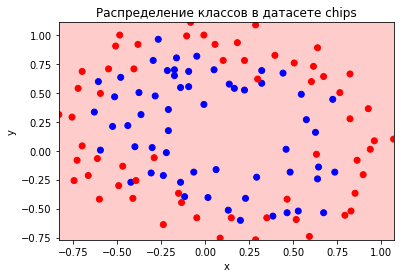

In [24]:
draw_plot_contour(alfa, X, y, linear, 'chips')

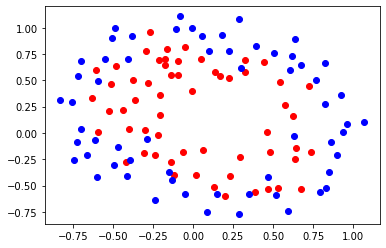

KeyboardInterrupt: 

In [43]:
# Линейное ядро

X, y = chips.values[:,:-1], chips.values[:,-1]
draw_plot(X, y)
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
params = list(product(C))
accs = []
for param in params:
    #clf = SVM(kernel=linear_kernel, C=param[0])
    acc_clf = []
    Xs_train, Xs_test, ys_train, ys_test = cross_validation_split(X, y)
    for i in range(len(Xs_train)):
        #clf.fit(Xs_train[i], ys_train[i])
        alfa, b = fit(Xs_train[i], ys_train[i], linear, param[0])
        #y_pred = clf.predict(Xs_test[i])
        y_pred = []
        for obj in Xs_test[i]:
            y_pred.append(predict(alfa, obj, Xs_test[i], ys_test[i], linear, b))
        acc_clf.append(accuracy_score(np.array(y_pred), ys_test[i]))
    accs.append(sum(acc_clf) / len(acc_clf))
print(f'Chips, Линейное ядро, Лучшая точность: {accs[accs.index(max(accs))]}, C: {params[accs.index(max(accs))][0]}')

#clf = SVM(kernel=linear_kernel, C=params[accs.index(max(accs))][0])
alfa, b = fit(X, y, linear, params[accs.index(max(accs))][0])
draw_plot_contour(alfa, X, y, linear, 'chips')